In [1]:
# unicode arabic 
# https://unicode.org/charts/PDF/U0600.pdf
# https://unicode.org/charts/PDF/UFE70.pdf

# mazajak cbow
# http://mazajak.inf.ed.ac.uk:8000/get_cbow_250
# http://mazajak.inf.ed.ac.uk:8000/get_sg_250

# !python3 -m pip install farasapy


In [2]:
import json
import os
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import random
import re
import requests
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from typing import Callable, Tuple, Union
from pylab import rcParams

rcParams["figure.figsize"] = (16,9)

try:
    STOP_WORDS_BASIC = stopwords.words("arabic")
except LookupError:
    nltk.download("stopwords")
    STOP_WORDS_BASIC = stopwords.words("arabic")

# from farasa.segmenter import FarasaSegmenter
random.seed(42)
np.random.seed(42)

DATA_PATH_CSV = "../input/dialect-dataset/"
# DATA_PATH_PKL = "../input/dialectdataset/"
DATA_PATH_PKL = "../input/aim-task/"
DATA_PATH_OUT = "../working/"
AIM_URI = "https://recruitment.aimtechnologies.co/ai-tasks"
ID_LIMIT = 1000
STOP_WORDS_BASIC = stopwords.words("arabic")
FILENAME = "dialect_dataset"
MAX_LENGTH = 1024  # FIXME should be determined by EDA


---

## functions for fetching data


In [3]:
def fetch_tweets_by_id(ids: list, object_hook: Callable = None) -> dict:
    """preforms a POST request to the AIM_URI, and returns the dictionary of
        id:tweet on success, raises an Exception on failure. The function
        handles the limit for the AIM_URI using `ID_LIMIT` constant

    Parameters
    ----------
    ids: array-like
        a list or array holding the IDs to retrieve, each is of type str

    Returns
    -------
    out: dict
        a dictionary where the keys are the given IDs and the corresponding
        values are the documents

    Raises
    ------
    FIXME add proper raises
    """
    tweets = {}
    for i in range(0, len(ids), ID_LIMIT):
        data = json.dumps(ids[i : i + ID_LIMIT])
        res = requests.post(AIM_URI, data)
        if res.ok:
            res.encoding = "utf8"
            i_docs = json.loads(res.text, object_hook=object_hook)
            tweets.update(i_docs)
        else:
            raise Exception("FIXME: check status code of response")
    return tweets


def check_cached_data() -> bool:
    """checks if the data has been loaded before and cached

    FIXME complete the pydoc
    """
    filename = FILENAME + ".pkl"
    for _, _, filenames in os.walk(DATA_PATH_PKL):
        if filename in filenames:
            return True
    return False


def load_local_dataset() -> pd.DataFrame:
    """loads the local dataset

    FIXME complete the pydoc
    """
    file_path = os.path.join(DATA_PATH_CSV, FILENAME + ".csv")
    df = pd.read_csv(file_path, index_col=["id"])
    df["dialect"] = df["dialect"].astype("category")
    return df


def fetch_remote_dataset(ids: list, object_hook: Callable = None) -> pd.DataFrame:
    """fetches the dataset by POSTing to URI

    FIXME complete the pydoc
    """
    tweets = fetch_tweets_by_id(ids, object_hook=object_hook)
    return pd.DataFrame(
        tweets.values(), index=[int(k) for k in tweets.keys()], columns=["tweets"]
    )


def load_full_dataset(
    force: bool = False, cache: bool = True, object_hook: Callable = None
) -> pd.DataFrame:
    """loads the full dataset

    # FIXME complete the pydoc
    """
    if not force and check_cached_data():
        cached_file_path = os.path.join(DATA_PATH_PKL, FILENAME + ".pkl")
        return pickle.load(open(cached_file_path, "rb"))
    else:
        local_df = load_local_dataset()
        ids = local_df.index.values.astype(str).tolist()
        remote_df = fetch_remote_dataset(ids, object_hook=object_hook)
        full_df = local_df.join(remote_df, on=local_df.index)
        if cache:
            cached_file_path = os.path.join(DATA_PATH_OUT, FILENAME + ".pkl")
            pickle.dump(full_df, open(cached_file_path, "wb"))
        return full_df


## Function for loading saved `sklearn` models


In [4]:
def load_classic_model(name: str = "benchmark"):
    """loads a classic ML model saved as `.pkl` pickled file

    Parameters:
    -----------

    Returns:
    --------

    Raises:
    -------

    TODO complete the pydoc
    """
    path = os.path.join(DATA_PATH_PKL, f"models/{name}.pkl")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Could not find model {name}!")
    return pickle.load(open(path, "rb"))


## Function to save validation set to disk


In [5]:
def store_validation_set(
    df: pd.DataFrame, set_size: float = 0.2
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """stores a copy of validation set on disk

    FIXME complete pydoc
    """
    y = df["dialect"]
    train_df, valid_df = train_test_split(
        df, test_size=set_size, random_state=42, stratify=y
    )
    valid_set_path = os.path.join(DATA_PATH_OUT, "valid.pkl")
    pickle.dump(valid_df, open(valid_set_path, "wb"))
    return train_df, valid_df


--- 

## Fetching the data


In [6]:
full_df = load_full_dataset()
# keep a validation set aside
df, _ = store_validation_set(full_df)

del _


---

## preprocessing


In [7]:
REGEX_HANDLER = r"(?u)@\w+"
REGEX_HYPERLINK = r"(?u)https?://\w+"
REGEX_HASHTAG = r"(?u)#(\w+)"
# to capture letters that repeat over 3 times
REGEX_CHAR_3_PLUS = r"(?u)(?=(\w))\1{3,}"

# to capture non-arabic, & non-farsi unicodes
REGEX_NOT_ARA_IRA = r"(?u)\b[^\u0600-\u06ff\ufe70-\ufefc_]+\b"

# to capture most common arabic glyphs
REGEX_RANGE_ARA = r"\ufe70-\ufefc\u0621-\u063a\u0640-\u0652\u060c\u061f"
REGEX_NOT_ARA = r"(?u)\b[^"+ REGEX_RANGE_ARA + "]+\b"

# converting farsi glyphs into arabic
REGEX_IRA2ARA = {
    r"\u06fd": "\u0621",
    r"[\u0676\u0677]": "\u0624",
    r"[\u0678\u06d3]": "\u0626",
    r"[\u0622\u0623\u0625\u0671-\u0675]": "\u0627",
    r"[\u067b\u067e\u0680]": "\u0628",
    r"[\u067a\u067c\u067d\u067f]": "\u062a",
    r"[\u0686\u0687]": "\u062c",
    r"[\u0688-\u068b\u068d]": "\u062f",
    r"[\u068c\u068e-\u0690]": "\u0630",
    r"[\u066b\u0691-\u0695]": "\u0631",
    r"[\u0696-\u0699]": "\u0632",
    r"[\u069a\u069b]": "\u0633",
    r"\u069c": "\u0634",
    r"\u060f": "\u0639",
    r"\u06d4": "\u0640",
    r"[\u06a4\u06a5]": "\u0641",
    r"\u06a8\u06a6": "\u0642",
    r"[\u063b\u063c\u06a9-\u06b4]": "\u0643",
    r"[\u06b5-\u06b8]": "\u0644",
    r"\u06fe": "\u0645",
    r"[\u06b9-\u06bd]": "\u0646",
    r"[\u0629\u06be\u06c0-\u06c3\u06ff]": "\u0647",
    r"[\u06c4-\u06cb\u06cf]": "\u0648",
    r"[\u0620\u063d-\u063f\u0649\u06cc-\u06ce\u06d0-\u06d2\u06e6\u06e7]": "\u064a",
    r"[\u06d9\ufef5\ufef7\ufef9]": "\ufefb",
}


In [8]:
def regex_substitute(
    series: Union[list, np.ndarray, pd.Series], regex_holder_dict: dict
) -> pd.Series:
    """given an array-like, & a dictionary of RegExp:`placeholder`, the series
    is processed to replace each RegExp with the corresponding `placeholder`

    Parameters:
    -----------

    Returns:
    --------

    Raises:
    -------

    TODO complete the pydoc
    """
    if not isinstance(series, pd.Series):
        try:
            series = pd.Series(series, dtype=str)
        except:
            raise ValueError("Invalid series: not array-like")
    for regex, holder in regex_holder_dict.items():
        series = series.apply(lambda s: re.sub(regex, holder, s))
    return series


def preprocess(data: Union[list, np.ndarray, pd.Series, pd.DataFrame]) -> pd.Series:
    """The actual preprocessing subroutine

    TODO complete pydoc

    """
    if isinstance(data, pd.DataFrame):
        if "tweets" not in data.columns:
            raise Exception("FIXME write a proper exception")
        # extract data as series
        data = data["tweets"]
    elif isinstance(data, list) or isinstance(data, np.ndarray):
        data = pd.Series(data, dtype=str)
    elif not isinstance(data, pd.Series):
        raise Exception("FIXME write a proper exception")

    # removing twitter specific features
    regex_twitter = {
        REGEX_HANDLER: r" ",
        REGEX_HYPERLINK: r" ",
        r"\d+": r" ",
        REGEX_HASHTAG: r"\1",
        r"_": r" ",
    }
    data = regex_substitute(data, regex_twitter)

    #     normalising the characters
    data = regex_substitute(data, REGEX_IRA2ARA)

    # removing any non-useful tokens
    extra_tokens = {
        REGEX_NOT_ARA: r" ",
        r"(?u)[\d\s_]+": r" ",
        REGEX_CHAR_3_PLUS: r"\1\1",
    }
    ara_ira = regex_substitute(data, extra_tokens)
    data = ara_ira.str.strip()

    # FIXME could use lemmatisation?

    return data


def init_preprocess(
    test_size: float = 0.1,
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """initialisation point for the training of the model

    TODO complete the pydoc
    """
    full_df = load_full_dataset()
    # keep a validation set aside
    df, _ = store_validation_set(full_df)

    df["tweets"] = preprocess(df["tweets"])

    # split data
    X = df["tweets"]
    y = df["dialect"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    del df

    # TODO do more preprocess

    return X_train, X_test, y_train, y_test


def build_tokeniser(
    corpus: Union[list, np.ndarray, pd.Series]
) -> tf.keras.preprocessing.text.Tokenizer:
    """instantiate and fits a `tensorflow.keras.preprocessing.Tokenizer` object
    on the given corpus, and returns the tokeniser

    Parameters:
    -----------

    TODO complete pydoc
    """
    tokeniser = tf.keras.preprocessing.text.Tokenizer()
    _ = tokeniser.fit_on_texts(corpus)
    return tokeniser


def tokenise_pad_texts(
    corpus: Union[list, np.ndarray, pd.Series],
    tokeniser: tf.keras.preprocessing.text.Tokenizer = None,
    maxlen: int = MAX_LENGTH,
    padding: str = "post",
):
    """tokenises the documents in `corpus`, then pads the documents to the
    `maxlen` length

    Parameters:
    -----------

    TODO complete pydoc
    """
    if not tokeniser:
        tokeniser = build_tokeniser(corpus)
    elif not isinstance(tokeniser, tf.keras.preprocessing.text.Tokenizer):
        raise ValueError(
            "The tokeniser must be of type tensorflow.keras.preprocessing.Tokenizer"
        )
    tokens = tokeniser.texts_to_sequences(corpus)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(
        tokens, maxlen=maxlen, padding=padding
    )
    return padded_tokens


def onehot_encode_labels(labels: Union[list, np.ndarray, pd.Series]) -> np.ndarray:
    """performs one hot encoding on labels

    Parameters:
    -----------

    TODO complete pydoc
    """
    labels = pd.Series(labels, dtype="category")
    return tf.keras.utils.to_categorical(labels.cat.codes)


In [9]:
# segmenter = FarasaSegmenter()
# v_segment = np.vectorize(segmenter.segment)
# step = 1024
# tweets = df['tweets'].values
# lem_text = df['tweets'].apply(segmenter.segment)
# lem_text.sample(1)
# for idx in np.arange(0, df.shape[0], step):
#     tweets[idx:idx+step] = v_segment(tweets[idx:idx+step])
#     print(idx)


[]

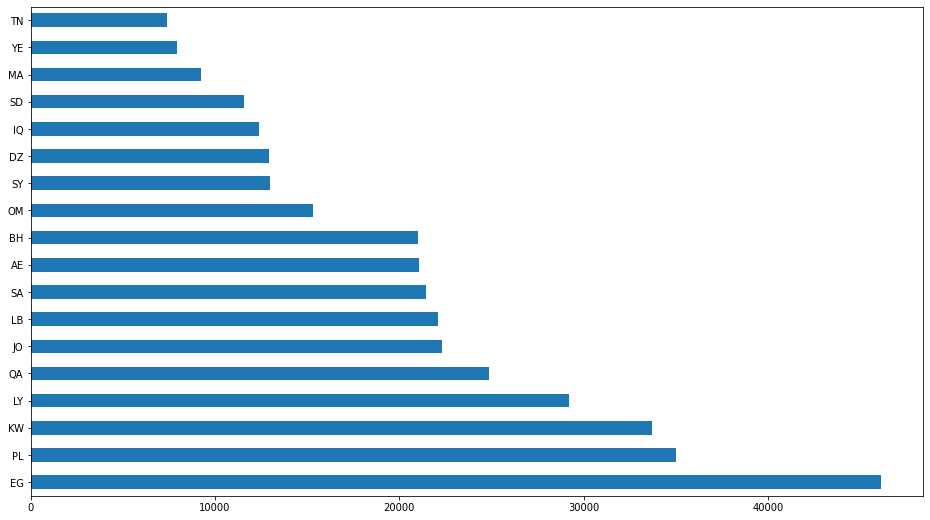

In [10]:
df['dialect'].value_counts().plot.barh()
plt.plot()


In [11]:
df_cpy = df.copy()
regex_twitter = {
    REGEX_HANDLER: r"<HNDL/>",
    REGEX_HYPERLINK: r"<URL/>",
    r"\d+": r"<NUM/>",
}


In [12]:
df_cpy["tweets"] = regex_substitute(df_cpy["tweets"], regex_twitter)


In [13]:
df_cpy["len"] = df["tweets"].apply(len)
df_cpy["word_count"] = (
    df["tweets"].apply(lambda s: re.findall(r"(?u)\b\w\w+\b", s)).apply(len)
)


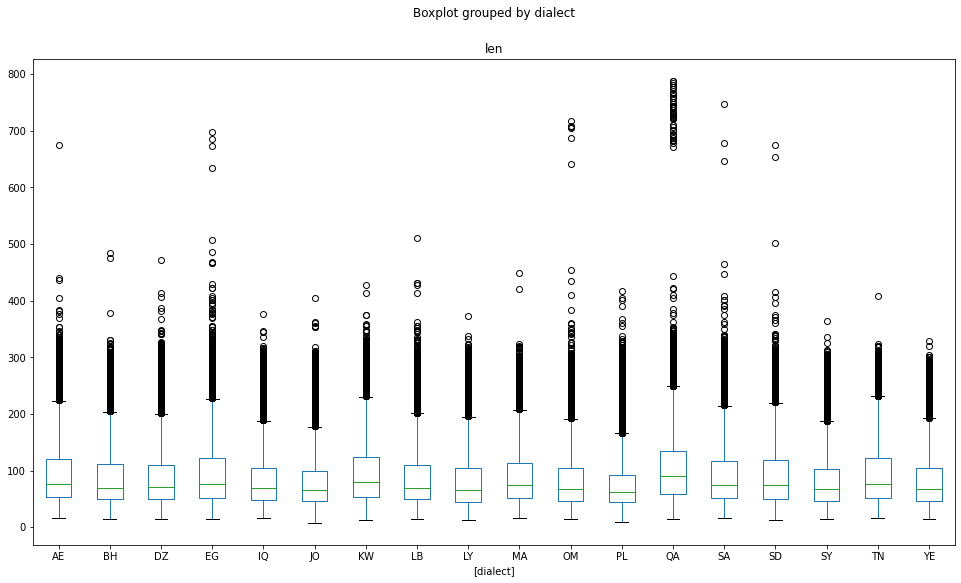

In [14]:
df_cpy[["len", "dialect"]].boxplot(by="dialect", grid=False)
plt.show()


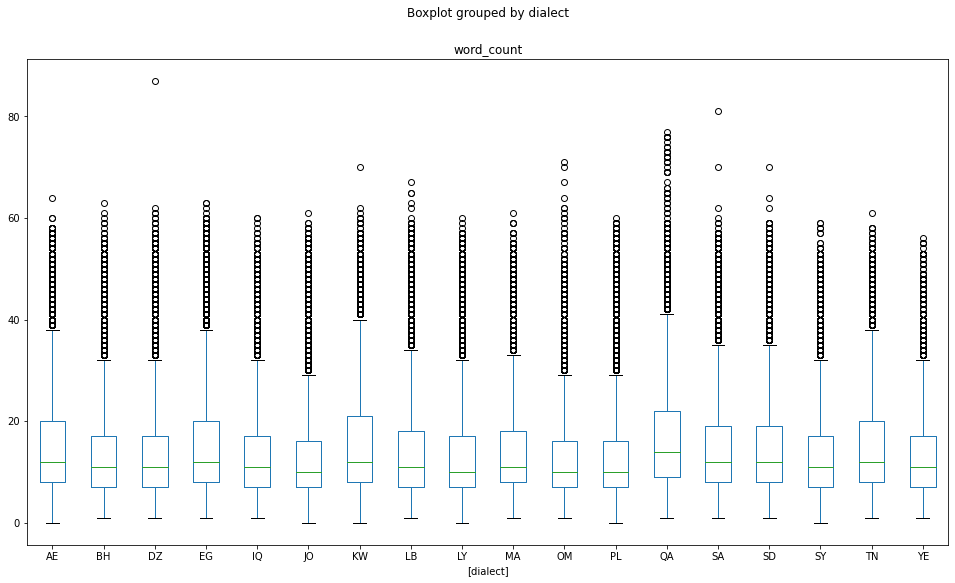

In [15]:
df_cpy[["word_count", "dialect"]].boxplot(by="dialect", grid=False)
plt.show()


In [16]:
# NOTE: the notebook might allocate too much memory
del df_cpy


In [17]:
X_train, X_test, y_train, y_test = init_preprocess()


--- 

## Model training


In [18]:
from itertools import chain


def tokeniser(string: str) -> list:
    """https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    https://stackoverflow.com/questions/5466451/how-can-i-print-literal-curly-brace-characters-in-a-string-and-also-use-format
    
    Parameters:
    -----------

    Returns:
    --------

    TODO complete pydoc
    """
    regex_c37 = r"(?u)(?=(\w{3}))" + "".join(
        [f"(?=(\\w{{,{i}}}))" for i in range(4, 8)]
    )
    regex_w26 = r"(?u)(?=(?!\W)(?=((?:\W*\b\w+\b){2}))" + "".join(
        [f"(?!\\W)(?=((?:\\W*\\b\w+\\b){{,{i}}}))" for i in range(3, 7)]
    )
    token_c37 = RegexpTokenizer(regex_c37).tokenize(string)
    token_w26 = RegexpTokenizer(regex_w26).tokenize(string)
    tokens = set(chain(*(token_c37 + token_w26)))
    return sorted(tokens)


def build_naive_bayes_model(*args, **kwargs):
    """builds and returns an sklearn pipeline


    TODO complete the pydoc
    """
    if "stop_words" not in kwargs:
        kwargs["stop_words"] = STOP_WORDS_BASIC
    model = MultinomialNB(alpha=kwargs.get("alpha", 1))
    if "alpha" in kwargs:
        del kwargs["alpha"]
    vectoriser = CountVectorizer(**kwargs)

    return make_pipeline(vectoriser, model)


In [19]:
# building a benchmark model
bench = build_naive_bayes_model(stop_words=None)

_ = bench.fit(X_train, y_train)
y_pred = bench.predict(X_test)
clf_report = classification_report(y_test, y_pred, labels=y_train.unique())
print(clf_report)

# TODO train better models


              precision    recall  f1-score   support

          DZ       0.82      0.33      0.47      1295
          EG       0.50      0.95      0.66      4611
          BH       0.46      0.14      0.22      2103
          LY       0.65      0.67      0.66      2920
          AE       0.52      0.29      0.38      2104
          KW       0.32      0.77      0.46      3369
          JO       0.57      0.14      0.23      2234
          IQ       0.93      0.28      0.43      1240
          YE       0.79      0.01      0.03       794
          OM       0.82      0.09      0.16      1529
          LB       0.69      0.63      0.66      2209
          SY       0.92      0.08      0.15      1299
          QA       0.42      0.53      0.47      2486
          PL       0.39      0.66      0.49      3499
          SA       0.50      0.30      0.37      2146
          TN       0.98      0.14      0.25       740
          MA       0.94      0.42      0.58       923
          SD       0.95    

In [20]:
# NOTE notebook might allocate too much memory
pickle.dump(bench, open("benchmark.pkl", "wb"))
del bench


In [21]:
def analyser(*args):
    """to allow BoW to be built using a combination of character &
    word n-grams. using `lambda` expression makes the model non-pickle friendly

    TODO complete pydoc
    """
    return args


combined = build_naive_bayes_model(
    alpha=0.1, stop_words=STOP_WORDS_BASIC, analyzer=analyser, tokenizer=tokeniser
)


In [22]:
# NOTE notebook might allocate too much memory
pickle.dump(combined, open("combined.pkl", "wb"))
del combined


In [23]:
model_w26 = build_naive_bayes_model(stop_words=STOP_WORDS_BASIC, ngram_range=(2, 6))


In [24]:
# NOTE notebook might allocate too much memory
pickle.dump(model_w26, open("model_w26.pkl", "wb"))
del model_w26


In [25]:
model_c37 = build_naive_bayes_model(
    alpha=0.1, stop_words=STOP_WORDS_BASIC, analyzer="char", ngram_range=(3, 7)
)


In [26]:
# NOTE notebook might allocate too much memory
pickle.dump(model_c37, open("model_c37.pkl", "wb"))
del model_c37


---


In [27]:
scoring = [
    "neg_log_loss",
    "f1_micro",
]  # , "f1_macro", "precision_micro", "recall_micro"]
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
labels = y.unique()


In [28]:
# # models = ["combined", "model_c37", "model_w26"]
# result = {}
# for model in models:
#     mod = pickle.load(open(f"{model}.pkl", "rb"))
#     result[model] = cross_validate(mod, X, y, scoring=scoring)
#     del mod



In [29]:
# for model in result:
#     for key, val in result[model].items():
#         result[model][key] = np.mean(val)
#     print(result[model])

# f1_scores = [r['test_f1_micro'] for r in result.values()]
# neg_log_loss = [r['test_neg_log_loss'] for r in result.values()]
# print(models[np.argmax(f1_scores)], models[np.argmin(neg_log_loss)])


In [30]:
# model = models[np.argmax(f1_scores)]


In [31]:
# mod = pickle.load(open(f"{model}.pkl", "rb"))
# _ = mod.fit(X_train, y_train)
# y_pred = mod.predict(X_test)
# clf_report = classification_report(y_test, y_pred, labels=labels)
# print(clf_report)


In [32]:
# pickle.dump(mod, open(f"{model}.pkl", "wb"))

# del mod

In [33]:
# TODO TfidfVectorizer
# TODO SVC


---


In [34]:
tknsr = build_tokeniser(pd.concat([X_train, X_test]).values)
X_train_padded = tokenise_pad_texts(X_train, tknsr)
X_test_padded = tokenise_pad_texts(X_test, tknsr)

y1h = onehot_encode_labels(pd.concat([y_train, y_test]))
y_train1h = y1h[:y_train.shape[0]]
y_test1h = y1h[y_train.shape[0]:]


In [35]:
model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(
            len(tknsr.word_counts) + 1,
            128,
            embeddings_initializer=tf.keras.initializers.RandomUniform(),
            input_length=MAX_LENGTH,
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(y_train1h.shape[1], activation="softmax"),
    ],
    name="deep_classifier",
)

model.compile("adam", "categorical_crossentropy", metrics=["categorical_accuracy"])


2022-03-12 14:07:35.320780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 14:07:35.418814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 14:07:35.419859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 14:07:35.422057: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [36]:
_ = model.fit(
    X_train_padded,
    y_train1h,
    batch_size=32,
    epochs=2,
    verbose=1,
    validation_data=(X_test_padded, y_test1h),
)


2022-03-12 14:07:38.195284: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351274496 exceeds 10% of free system memory.
2022-03-12 14:07:39.249590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-03-12 14:07:42.633418: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10310/10310 [==============================] - 970s 94ms/step - loss: 1.8996 - categorical_accuracy: 0.3978 - val_loss: 1.5984 - val_categorical_accuracy: 0.5005
Epoch 2/2
10310/10310 [==============================] - 973s 94ms/step - loss: 1.2324 - categorical_accuracy: 0.6191 - val_loss: 1.5862 - val_categorical_accuracy: 0.5233


In [37]:
model_json = model.to_json()
json.dump(json.loads(model_json), open('rnn_model.json', "w"))
model.save_weights('rnn_model_weights.h5')


In [38]:
# TODO transfer learning & transformers
